# Final Project - Facial Expression Classification

## Packages that Might Be Used

In [1]:
# turn off convergence warning 'cause it's annoying
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [2]:
import pandas as pd
import numpy as np
import os

import keras
from keras.preprocessing.image import image, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, Conv2D, Flatten, MaxPooling2D   
from keras.optimizers import RMSprop

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
C:\Users\Candy\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Candy\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Candy\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Candy\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Functions

In [3]:
def plot_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

## About Dataset

* [read and show image](https://www.itread01.com/content/1544534479.html)
* [read documents under file](https://newaurora.pixnet.net/blog/post/228299675-python%E8%AE%80%E5%8F%96%E8%B3%87%E6%96%99%E5%A4%BE%E5%85%A7%E6%AA%94%E6%A1%88)

In [67]:
datasetPath = 'D:/讀書區/大四下/機器學習概論/final project/face3-2/'
TrainingFileList = os.listdir(datasetPath + 'Training/')
TestingFileList = os.listdir(datasetPath + 'Testing/')

#emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
emotions = ['Angry-Disgust', 'Happy', 'Neutral', 'Sad', 'Disgust-Surprise']

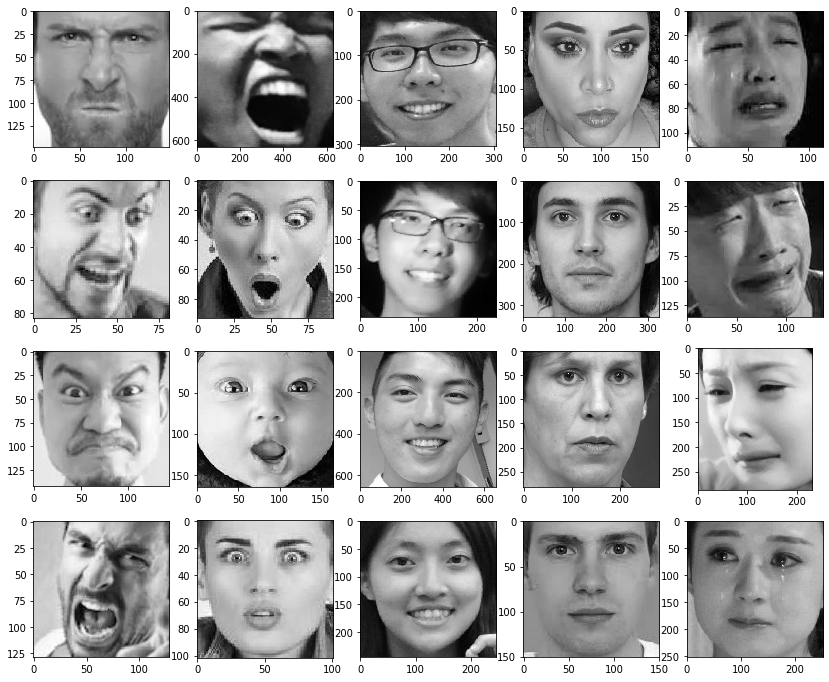

In [68]:
plt.figure(0, figsize=(20,12))

index = 0
for expression in TrainingFileList:
    index += 1
    for i in range(0,4):
        plt.subplot(4,5,5*i+index)
        img = image.load_img(datasetPath + 'Training/' + expression + "/" + os.listdir(datasetPath + 'Training/'+expression)[i], color_mode='grayscale')
        plt.imshow(img, cmap='gray')
    
plt.show()

In [69]:
print('<Training Data Size>')
for expression in TrainingFileList:
    print(expression + ":" + str(len(os.listdir(datasetPath + 'Training/' + expression))))

print('<Testing Data Size>')
for expression in TestingFileList:
    print(expression + ":" + str(len(os.listdir(datasetPath + 'Testing/' + expression))))

<Training Data Size>
Angry:100
Fear:100
Happy:100
Neutral:100
Sad:100
<Testing Data Size>
Angry:20
Fear:20
Happy:20
Neutral:20
Sad:20


## Load Dataset

* [ImageDataGenerator](https://www.itread01.com/content/1546542668.html)
* [Facial Recognition Model trained by keras](https://www.itread01.com/content/1541822010.html)

In [70]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

batch_size = 20

train_generator = train_datagen.flow_from_directory(
                datasetPath + 'Training/',
                target_size = (48,48),
                batch_size = batch_size,
                class_mode = 'categorical', 
                color_mode= 'grayscale',
                shuffle = 'True')

test_generator = test_datagen.flow_from_directory(
                datasetPath + 'Testing/',
                target_size = (48,48),
                batch_size = batch_size,
                class_mode = 'categorical', 
                color_mode = 'grayscale',
                shuffle = 'True')

Found 500 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [71]:
X_train = []
y_train = []
X_test = []
y_test = []
index = 0
for expression in TrainingFileList:
    for i in range(0,int(train_generator.samples/5)):
        train_img = image.load_img(datasetPath + 'Training/' + expression + "/" + os.listdir(datasetPath + 'Training/'+expression)[i], target_size = (48,48), color_mode='grayscale')
        train_img = image.img_to_array(train_img)
        X_train.append(train_img)
        y_train.append(expression)
        index += 1
        
index = 0
for expression in TrainingFileList:
    for i in range(0,int(test_generator.samples/5)):
        test_img = image.load_img(datasetPath + 'Testing/' + expression + "/" + os.listdir(datasetPath + 'Testing/'+expression)[i], target_size = (48,48), color_mode='grayscale')
        test_img = image.img_to_array(test_img)
        X_test.append(test_img)
        y_test.append(expression)
        index += 1


X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = X_train.reshape(500,2304)
X_test = X_test.reshape(100,2304)

(500, 48, 48, 1)
(500,)
(100, 48, 48, 1)
(100,)


In [72]:
state=np.random.get_state()
np.random.shuffle(X_train)
np.random.set_state(state)
np.random.shuffle(y_train)
np.random.set_state(state)
np.random.shuffle(X_test)
np.random.set_state(state)
np.random.shuffle(y_test)

## DECISION TREE

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

print('Decision Tree acc:', metrics.accuracy_score(y_test, y_pred))

Decision Tree acc: 0.22


## Random Forest

In [74]:
rf_clf = RandomForestClassifier(n_estimators = 100)
rf_clf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print('Random Forest acc:', metrics.accuracy_score(y_test, y_pred))

Random Forest acc: 0.37


## Naive Bayes

In [75]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

gnb = GaussianNB()
clf = BernoulliNB()
mlf = MultinomialNB()
y_gnb = gnb.fit(X_train, y_train).predict(X_test)
y_clf = clf.fit(X_train, y_train).predict(X_test)
y_mlf = mlf.fit(X_train, y_train).predict(X_test)
y_gnb_accuracy = (y_test == y_gnb).sum() / len(y_test)
y_clf_accuracy = (y_test == y_clf).sum() / len(y_test)
y_mlf_accuracy = (y_test == y_mlf).sum() / len(y_test)
print('Gaussian: %f' % (y_gnb_accuracy))
print('Bernoulli: %f' % (y_clf_accuracy))
print('Multinomial: %f' % (y_mlf_accuracy))

Gaussian: 0.300000
Bernoulli: 0.230000
Multinomial: 0.270000


## Model --- Logistic Regression

In [76]:
#parameters = {'C':[1, 100], 'tol':[0.01], 'penalty':['l2'], 'solver':['saga','lbfgs'], 'warm_start':['True','False']}
#parameters = {'C':[1, 100], 'tol':[0.01], 'penalty':['l2'], 'solver':['liblinear','saga','lbfgs'], 'warm_start':['True','False'], 'multi_class':['multinomial']}
parameters = {'C':[1, 100], 'tol':[0.01], 'penalty':['l2'], 'solver':['saga','lbfgs'], 'warm_start':['True','False'], 'multi_class':['multinomial']}

lr_grid = GridSearchCV(estimator = LogisticRegression(), param_grid = parameters)
lr_grid = lr_grid.fit(X_train, y_train)

In [77]:
best_model_lr = lr_grid.best_estimator_
print(best_model_lr)

best_model_lr = best_model_lr.fit(X_train, y_train)
y_pred = best_model_lr.predict(X_test)
print('lr acc:', metrics.accuracy_score(y_test, y_pred))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.01, verbose=0,
                   warm_start='True')
lr acc: 0.37


Confusion matrix, without normalization


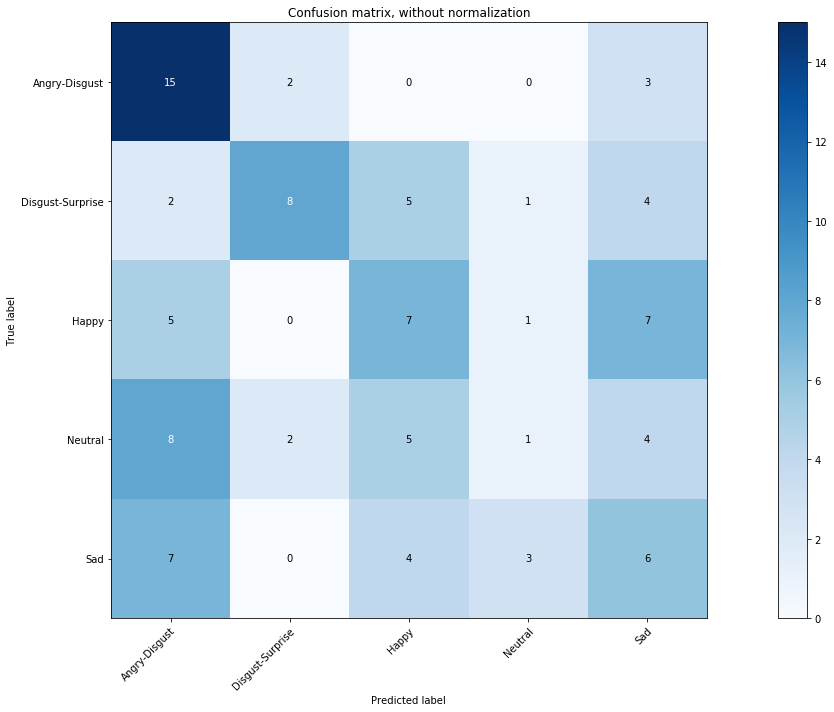

None


In [78]:
maxtrix = confusion_matrix(y_test, y_pred)
print(plot_confusion_matrix(maxtrix, classes = np.unique(emotions)))

##  Model --- KNN

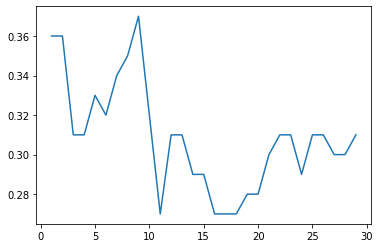

k for max acc: 8 
Max acc: 0.37


In [28]:
from sklearn.calibration import CalibratedClassifierCV

num_of_neighbor = [i for i in range(1,30)]
acc_knn = []
for i in num_of_neighbor:
    model_knn = KNeighborsClassifier(n_neighbors = i)
    model_knn = model_knn.fit(X_train, y_train)
    #

    #
    y_pred = model_knn.predict(X_test)
    
    acc_knn.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(num_of_neighbor,acc_knn)
plt.show()
print('k for max acc:',acc_knn.index(max(acc_knn)),'\nMax acc:',max(acc_knn))

Confusion matrix, without normalization


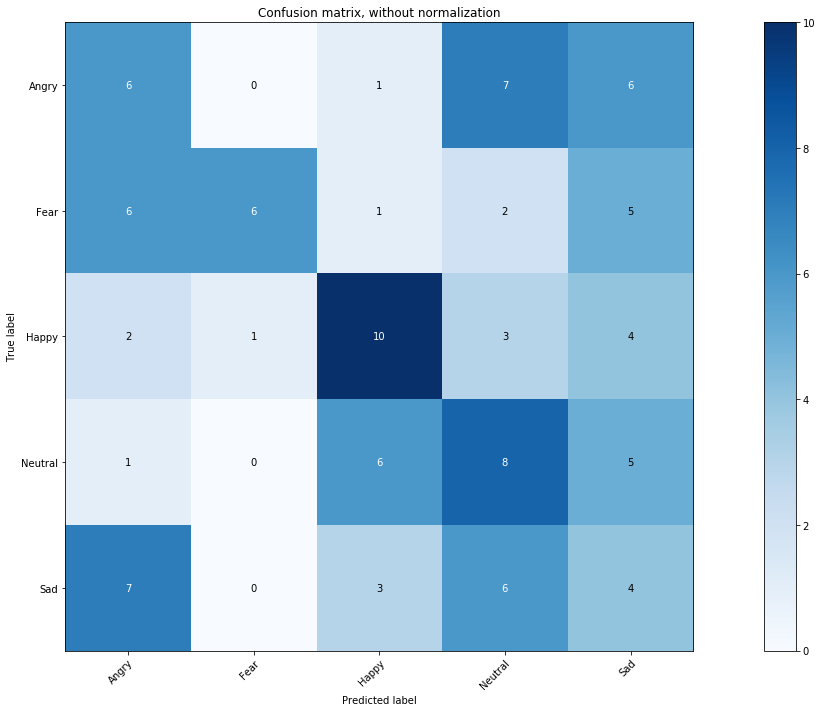

None


In [29]:
best_model_knn = KNeighborsClassifier(n_neighbors=7)
best_model_knn.fit(X_train,y_train)
y_pred = best_model_knn.predict(X_test)

maxtrix = confusion_matrix(y_test, y_pred)
print(plot_confusion_matrix(maxtrix, classes = np.unique(emotions)))

#### Model --- PCA KNN

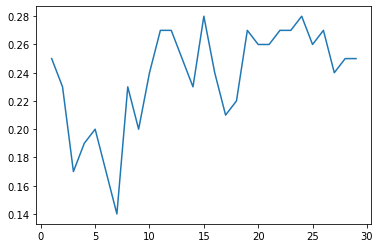

k for max acc: 14 
Max acc: 0.28


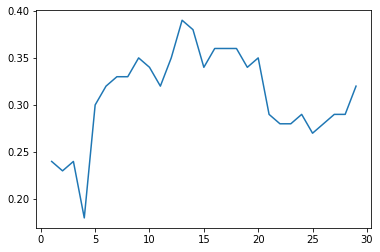

k for max acc: 12 
Max acc: 0.39


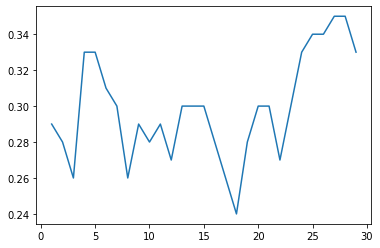

k for max acc: 26 
Max acc: 0.35


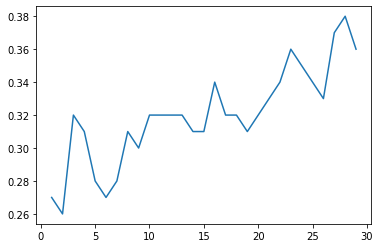

k for max acc: 27 
Max acc: 0.38


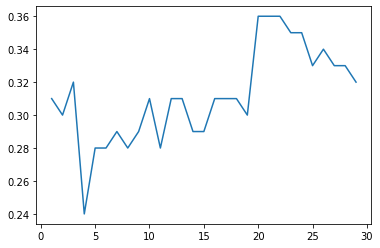

k for max acc: 19 
Max acc: 0.36


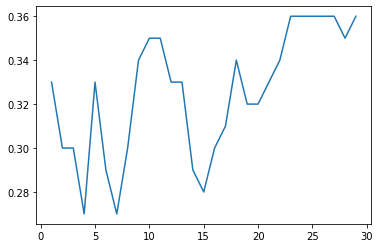

k for max acc: 22 
Max acc: 0.36


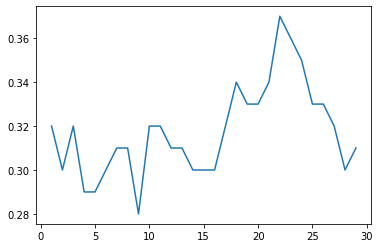

k for max acc: 21 
Max acc: 0.37


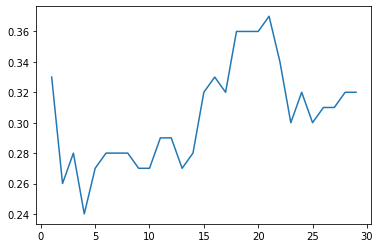

k for max acc: 20 
Max acc: 0.37


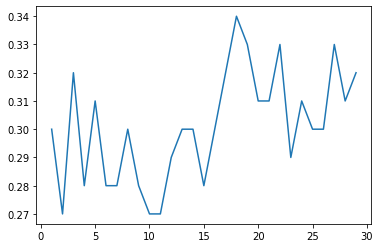

k for max acc: 17 
Max acc: 0.34


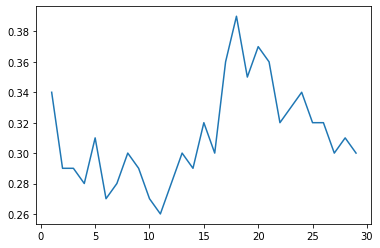

k for max acc: 17 
Max acc: 0.39


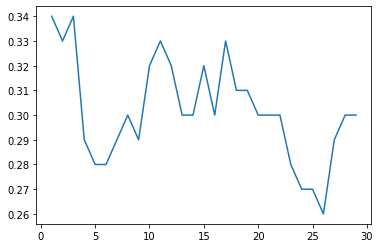

k for max acc: 0 
Max acc: 0.34


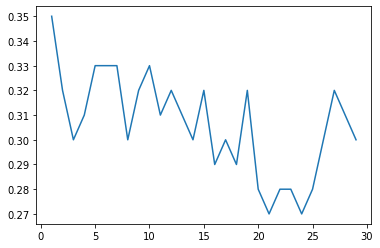

k for max acc: 0 
Max acc: 0.35


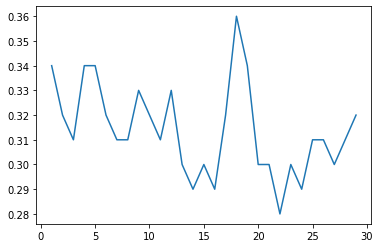

k for max acc: 17 
Max acc: 0.36


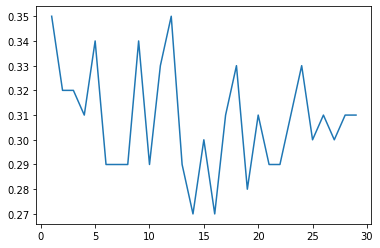

k for max acc: 0 
Max acc: 0.35


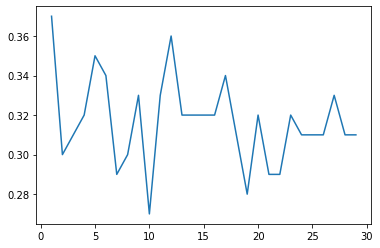

k for max acc: 0 
Max acc: 0.37


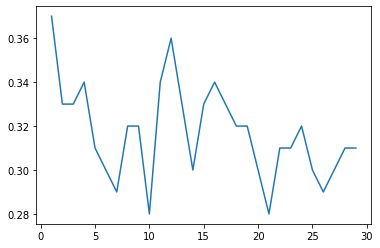

k for max acc: 0 
Max acc: 0.37


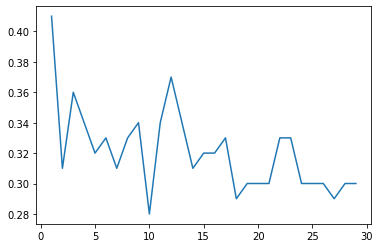

k for max acc: 0 
Max acc: 0.41


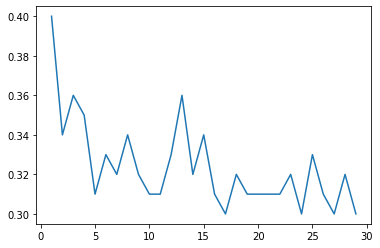

k for max acc: 0 
Max acc: 0.4


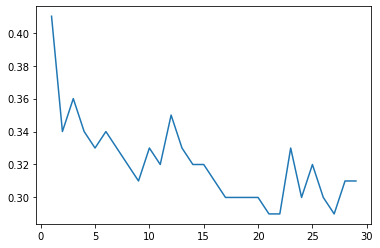

k for max acc: 0 
Max acc: 0.41


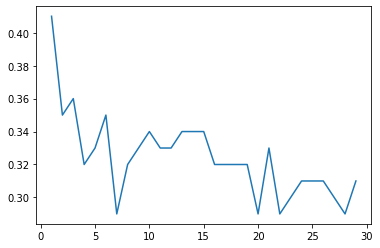

k for max acc: 0 
Max acc: 0.41


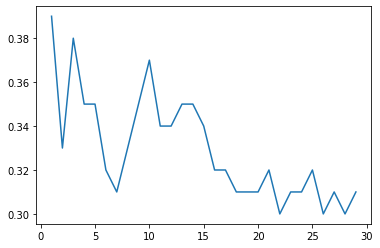

k for max acc: 0 
Max acc: 0.39


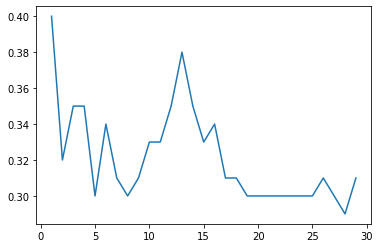

k for max acc: 0 
Max acc: 0.4


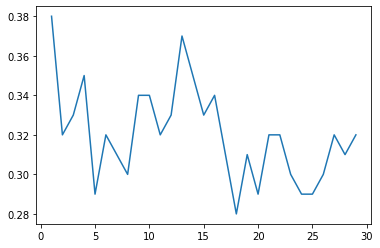

k for max acc: 0 
Max acc: 0.38


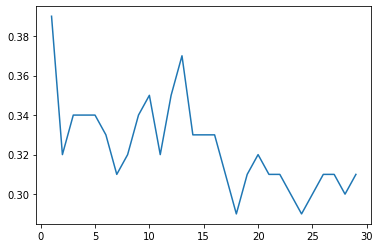

k for max acc: 0 
Max acc: 0.39


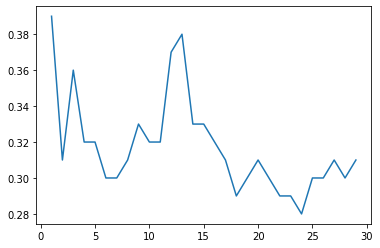

k for max acc: 0 
Max acc: 0.39


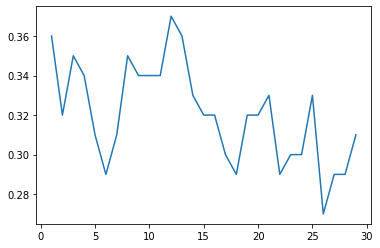

k for max acc: 11 
Max acc: 0.37


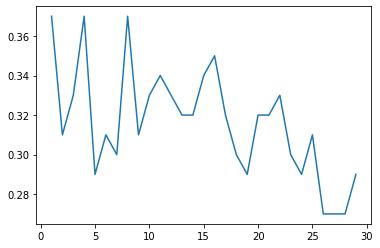

k for max acc: 0 
Max acc: 0.37


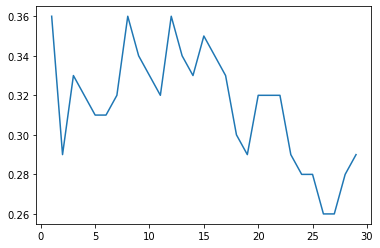

k for max acc: 0 
Max acc: 0.36


In [50]:
for j in range(1,29):
    pca = PCA(n_components = j)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    acc = []
    for i in num_of_neighbor:
        model_knn = KNeighborsClassifier(n_neighbors = i)
        model_knn.fit(X_train_pca, y_train)
        y_pred = model_knn.predict(X_test_pca)
        acc.append(metrics.accuracy_score(y_test, y_pred))

    plt.plot(num_of_neighbor,acc)
    plt.show()
    print('k for max acc:',acc.index(max(acc)),'\nMax acc:',max(acc))

## Model --- SVM

In [79]:
#parameters = {'C':[1, 10], 'kernel':['linear', 'rbf']}
parameters = {'C': [1, 100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
              'kernel':['linear', 'rbf']}
svc_grid = GridSearchCV(estimator = SVC(), param_grid = parameters)
svc_grid = svc_grid.fit(X_train, y_train)

In [80]:
best_model_svc= svc_grid.best_estimator_
print(best_model_svc)

best_model_svc = best_model_svc.fit(X_train, y_train)
y_pred = best_model_svc.predict(X_test)
print('svc acc:', metrics.accuracy_score(y_test, y_pred))

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc acc: 0.32


Confusion matrix, without normalization


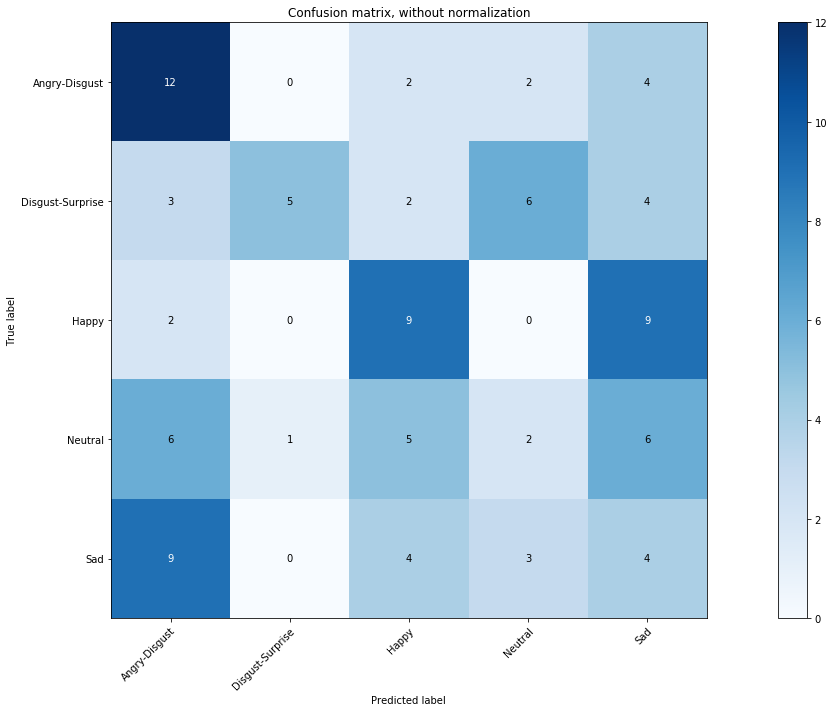

None


In [81]:
maxtrix = confusion_matrix(y_test, y_pred)
print(plot_confusion_matrix(maxtrix, classes = np.unique(emotions)))

## Model --- CNN
#### Build

In [129]:
# Initialising the CNN
model_cnn = Sequential(name='CNN')  

# Create CN layer 1  
model_cnn.add(Conv2D(filters=16, kernel_size=(3,3), 
                     padding='same',activation='relu', 
                     input_shape=(48,48,1)))

# Create Max-Pool 1  
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
  
# Add Dropout layer  
model_cnn.add(Dropout(0.25))

#Add Flatten Layer
model_cnn.add(Flatten())

#Add NN Layer
model_cnn.add(Dense(625, activation='relu'))

# Add Dropout layer  
model_cnn.add(Dropout(0.25))

#Add Output Layer 
model_cnn.add(Dense(5, activation='softmax'))

model_cnn.summary()  

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 24, 24, 16)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 625)               5760625   
_________________________________________________________________
dropout_34 (Dropout)         (None, 625)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 3130    

#### Compile and Fit

In [130]:
# Compile Part 
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  
# Fit part 
model_cnn_history = model_cnn.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.n//train_generator.batch_size,
        epochs = 50,
        validation_data = test_generator,
        validation_steps = test_generator.n//test_generator.batch_size)

Epoch 1/50
25/25 [==============================] - 5s 196ms/step - loss: 300.6342 - accuracy: 0.2060 - val_loss: 49.7838 - val_accuracy: 0.2100
Epoch 2/50
25/25 [==============================] - 4s 154ms/step - loss: 38.6841 - accuracy: 0.2340 - val_loss: 13.3503 - val_accuracy: 0.2700
Epoch 3/50
25/25 [==============================] - 4s 148ms/step - loss: 4.1003 - accuracy: 0.3580 - val_loss: 1.6855 - val_accuracy: 0.2500
Epoch 4/50
25/25 [==============================] - 4s 158ms/step - loss: 1.5286 - accuracy: 0.3220 - val_loss: 1.5760 - val_accuracy: 0.3300
Epoch 5/50
25/25 [==============================] - 4s 160ms/step - loss: 1.4897 - accuracy: 0.3480 - val_loss: 1.5894 - val_accuracy: 0.2200
Epoch 6/50
25/25 [==============================] - 4s 164ms/step - loss: 1.4834 - accuracy: 0.3600 - val_loss: 1.5284 - val_accuracy: 0.2200
Epoch 7/50
25/25 [==============================] - 4s 164ms/step - loss: 1.3705 - accuracy: 0.4340 - val_loss: 1.5336 - val_accuracy: 0.2300
E

#### Result

In [131]:
train_acc = model_cnn.evaluate_generator(train_generator)
test_acc = model_cnn.evaluate_generator(test_generator)
print("Train accuracy: ",train_acc[1])
print("Test accuracy: ",test_acc[1])

Train accuracy:  0.9980000257492065
Test accuracy:  0.4399999976158142


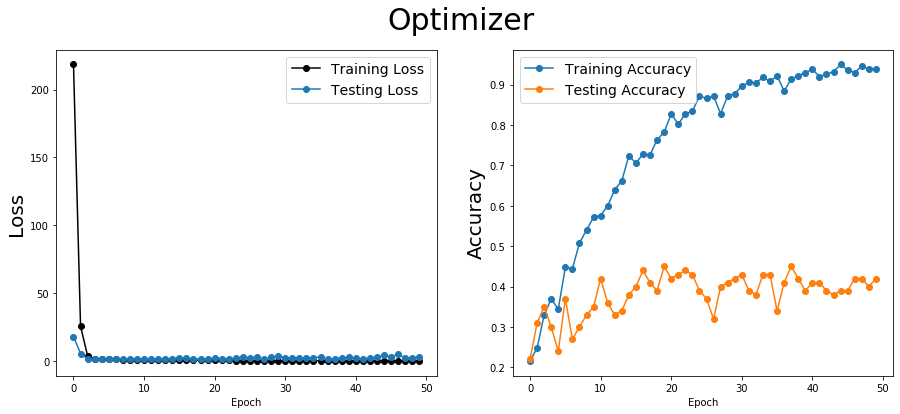

In [127]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.suptitle('Optimizer',fontsize=30)
plt.xlabel('Epoch')
plt.ylabel('Loss',fontsize=20)
plt.plot(model_cnn_history.history['loss'], label='Training Loss', color='k', marker='o')
plt.plot(model_cnn_history.history['val_loss'],label='Testing Loss', marker='o')
plt.legend(loc='upper right',fontsize=14)

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy',fontsize=20)
plt.plot(model_cnn_history.history['accuracy'],label='Training Accuracy', marker='o')
plt.plot(model_cnn_history.history['val_accuracy'],label='Testing Accuracy', marker='o')
plt.legend(loc='upper left',fontsize=14)

plt.show()

Confusion matrix, without normalization


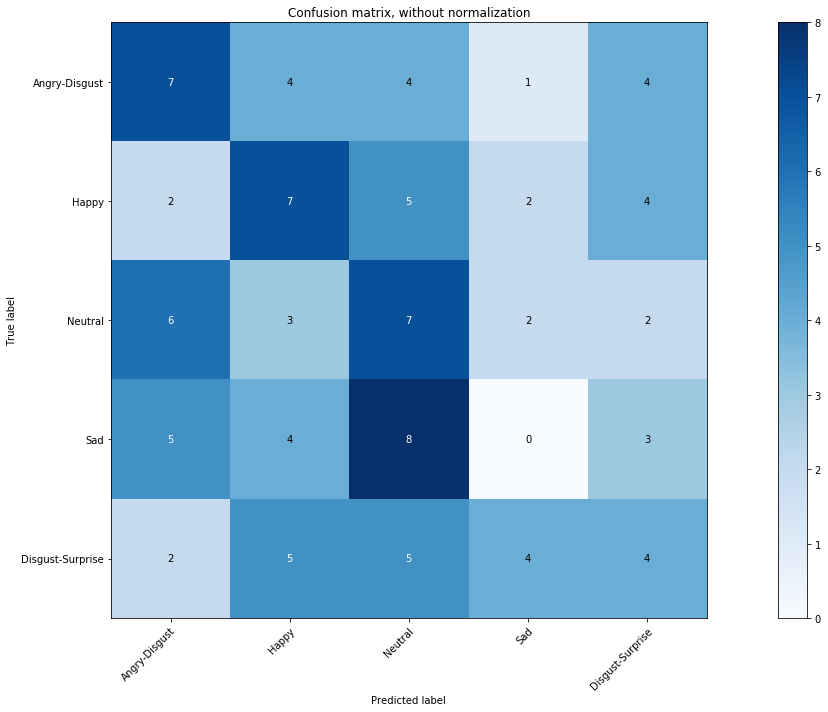

None


In [128]:
predictions = model_cnn.predict_generator(generator=test_generator)
y_pred = [np.argmax(p) for p in predictions]
y_test = test_generator.classes

maxtrix = confusion_matrix(y_test, y_pred)
print(plot_confusion_matrix(maxtrix, classes = emotions))

## Further Test

Logistic Regression: ['Happy']
KNN: ['Sad']
SVC: ['Sad']
CNN: [[0.01535528 0.14308731 0.3995699  0.1099954  0.33199206]]
['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']


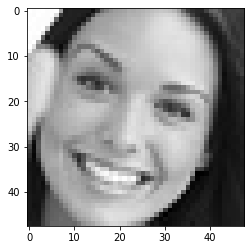

In [32]:
test_img = image.load_img(datasetPath + 'image.jpg', target_size = (48,48), color_mode='grayscale')
plt.imshow(test_img, cmap='gray')
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis = 0)

result_cnn = model_cnn.predict(test_img)

test_img = test_img.reshape(1,2304)
result_lr = best_model_lr.predict(test_img)
result_knn = best_model_knn.predict(test_img)
result_svc = best_model_svc.predict(test_img)

print('Logistic Regression:',result_lr)
print('KNN:',result_knn)
print('SVC:',result_svc)
print('CNN:',result_cnn)

print(emotions)